과제1_0524.
산탄데르 고객 만족 예측 모델을 생성하고 아래를 참조하여 평가를 수행하세요(XGBoost 모델 학습과 하이퍼 파라미터 튜닝)
- 데이터 읽어오기 : cust_df = pd.read_csv("./dataset/santander/train_santander.csv", encoding='latin-1')
- 데이터 전처리 : var3 피처 값 최빈값 2로 대체 및 ID 피처 드롭
- 데이터 분리 : 학습, 검증, 평가용
- 검색공간 설정 
    - max_depth는 5에서 15까지 1간격으로, 
    - min_child_weight는 1에서 6까지 1간격으로 
    - colsample_bytree는 0.5에서 0.95사이, 
    - learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 설정
- 목적함수 설정
- 최적 하이퍼파라미터 산출
- 최적 하이퍼파라미터 기반 학습 및 예측
- 평가(ROC AUC)
- 변수 중요도 시각화

Kaggle Competitions<br>
Santander Customer Satisfaction<br>
Which customers are happy customers?

일선 지원 팀에서 최고 경영진에 이르기까지 고객 만족은 성공의 핵심 척도입니다. 만족도가 낮은 고객은 은행의 서비스를 더이상 이용하지 않습니다. 더우기 불만족 고객은 서비스 이용을 중단하기 전에 불만을 표현하는 경우가 거의 없습니다.

Santander Bank는 Kagglers에게 서비스 초기에 불만족한 고객을 식별할 수 있도록 도와달라고 요청하고 있습니다. 그렇게 하면 Santander는 시기를 놓치지 않고 고객의 행복을 개선하기 위한 사전 조치를 취할 수 있습니다.

이 대회에서는 수백 가지의 익명화된 기능을 사용하여 고객이 은행 업무 경험에 만족하는지 불만족하는지 예측하게 됩니다.

제출물은 예측 확률과 관찰 대상 사이의 ROC 곡선 아래 영역에서 평가됩니다.

상금 : U$ 60,000

https://www.kaggle.com/c/santander-customer-satisfaction

GridSearchCV 사용 사례

https://www.kaggle.com/code/johyunkang/santander-customer-satisfaction-test

### 데이터 전처리

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("./dataset/santander/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.var3.value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [3]:
# 0이면 만족한 고객, 1이면 불만을 가진 고객
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [4]:
# var3 피처 값 최빈값 2로 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))


피처 데이터 shape:(76020, 369)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [7]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

[149]	validation_0-auc:0.90500	validation_1-auc:0.83353
[150]	validation_0-auc:0.90513	validation_1-auc:0.83352
[151]	validation_0-auc:0.90531	validation_1-auc:0.83349
[152]	validation_0-auc:0.90548	validation_1-auc:0.83349
[153]	validation_0-auc:0.90551	validation_1-auc:0.83351
[154]	validation_0-auc:0.90563	validation_1-auc:0.83348
[155]	validation_0-auc:0.90572	validation_1-auc:0.83343
[156]	validation_0-auc:0.90579	validation_1-auc:0.83344
[157]	validation_0-auc:0.90591	validation_1-auc:0.83345
[158]	validation_0-auc:0.90621	validation_1-auc:0.83355
[159]	validation_0-auc:0.90630	validation_1-auc:0.83359
[160]	validation_0-auc:0.90643	validation_1-auc:0.83356
[161]	validation_0-auc:0.90657	validation_1-auc:0.83352
[162]	validation_0-auc:0.90672	validation_1-auc:0.83346
[163]	validation_0-auc:0.90694	validation_1-auc:0.83347
[164]	validation_0-auc:0.90714	validation_1-auc:0.83343
[165]	validation_0-auc:0.90720	validation_1-auc:0.83343
[166]	validation_0-auc:0.90727	validation_1-auc:

In [9]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [14]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

[46]	validation_0-auc:0.88228	validation_1-auc:0.83625                                                                 
[47]	validation_0-auc:0.88318	validation_1-auc:0.83603                                                                 
[48]	validation_0-auc:0.88406	validation_1-auc:0.83587                                                                 
[49]	validation_0-auc:0.88499	validation_1-auc:0.83567                                                                 
[50]	validation_0-auc:0.88567	validation_1-auc:0.83621                                                                 
[51]	validation_0-auc:0.88617	validation_1-auc:0.83640                                                                 
[52]	validation_0-auc:0.88688	validation_1-auc:0.83592                                                                 
[53]	validation_0-auc:0.88747	validation_1-auc:0.83641                                                                 
[54]	validation_0-auc:0.88846	validation

[82]	validation_0-auc:0.90020	validation_1-auc:0.83718                                                                 
[83]	validation_0-auc:0.90074	validation_1-auc:0.83709                                                                 
[84]	validation_0-auc:0.90102	validation_1-auc:0.83728                                                                 
[85]	validation_0-auc:0.90138	validation_1-auc:0.83751                                                                 
[86]	validation_0-auc:0.90155	validation_1-auc:0.83765                                                                 
[87]	validation_0-auc:0.90164	validation_1-auc:0.83763                                                                 
[88]	validation_0-auc:0.90170	validation_1-auc:0.83761                                                                 
[89]	validation_0-auc:0.90205	validation_1-auc:0.83762                                                                 
[90]	validation_0-auc:0.90245	validation

[39]	validation_0-auc:0.89170	validation_1-auc:0.82861                                                                 
[40]	validation_0-auc:0.89309	validation_1-auc:0.82975                                                                 
[41]	validation_0-auc:0.89324	validation_1-auc:0.82911                                                                 
[42]	validation_0-auc:0.89552	validation_1-auc:0.82967                                                                 
[43]	validation_0-auc:0.89671	validation_1-auc:0.82997                                                                 
[44]	validation_0-auc:0.89801	validation_1-auc:0.83066                                                                 
[45]	validation_0-auc:0.89859	validation_1-auc:0.83087                                                                 
[46]	validation_0-auc:0.89944	validation_1-auc:0.83136                                                                 
[47]	validation_0-auc:0.90083	validation

[75]	validation_0-auc:0.91973	validation_1-auc:0.83107                                                                 
[76]	validation_0-auc:0.92015	validation_1-auc:0.83147                                                                 
[77]	validation_0-auc:0.92044	validation_1-auc:0.83143                                                                 
[78]	validation_0-auc:0.92071	validation_1-auc:0.83193                                                                 
[79]	validation_0-auc:0.92112	validation_1-auc:0.83232                                                                 
[80]	validation_0-auc:0.92183	validation_1-auc:0.83284                                                                 
[81]	validation_0-auc:0.92233	validation_1-auc:0.83290                                                                 
[82]	validation_0-auc:0.92249	validation_1-auc:0.83322                                                                 
[83]	validation_0-auc:0.92302	validation

[52]	validation_0-auc:0.94317	validation_1-auc:0.83200                                                                 
[53]	validation_0-auc:0.94377	validation_1-auc:0.83222                                                                 
[54]	validation_0-auc:0.94421	validation_1-auc:0.83209                                                                 
[55]	validation_0-auc:0.94461	validation_1-auc:0.83226                                                                 
[56]	validation_0-auc:0.94480	validation_1-auc:0.83226                                                                 
[57]	validation_0-auc:0.94494	validation_1-auc:0.83221                                                                 
[58]	validation_0-auc:0.94502	validation_1-auc:0.83211                                                                 
[59]	validation_0-auc:0.94535	validation_1-auc:0.83220                                                                 
[60]	validation_0-auc:0.94568	validation

[11]	validation_0-auc:0.85254	validation_1-auc:0.81344                                                                 
[12]	validation_0-auc:0.85442	validation_1-auc:0.81525                                                                 
[13]	validation_0-auc:0.85777	validation_1-auc:0.81538                                                                 
[14]	validation_0-auc:0.85831	validation_1-auc:0.81600                                                                 
[15]	validation_0-auc:0.86014	validation_1-auc:0.81717                                                                 
[16]	validation_0-auc:0.86258	validation_1-auc:0.81812                                                                 
[17]	validation_0-auc:0.86392	validation_1-auc:0.82040                                                                 
[18]	validation_0-auc:0.86335	validation_1-auc:0.81748                                                                 
[19]	validation_0-auc:0.86497	validation

[47]	validation_0-auc:0.89710	validation_1-auc:0.82999                                                                 
[48]	validation_0-auc:0.89778	validation_1-auc:0.83047                                                                 
[49]	validation_0-auc:0.89892	validation_1-auc:0.83118                                                                 
[50]	validation_0-auc:0.89915	validation_1-auc:0.83171                                                                 
[51]	validation_0-auc:0.89996	validation_1-auc:0.83209                                                                 
[52]	validation_0-auc:0.90100	validation_1-auc:0.83210                                                                 
[53]	validation_0-auc:0.90176	validation_1-auc:0.83192                                                                 
[54]	validation_0-auc:0.90236	validation_1-auc:0.83188                                                                 
[55]	validation_0-auc:0.90295	validation

[0]	validation_0-auc:0.82730	validation_1-auc:0.80139                                                                  
[1]	validation_0-auc:0.84185	validation_1-auc:0.80782                                                                  
[2]	validation_0-auc:0.84905	validation_1-auc:0.81110                                                                  
[3]	validation_0-auc:0.85357	validation_1-auc:0.81297                                                                  
[4]	validation_0-auc:0.85984	validation_1-auc:0.81412                                                                  
[5]	validation_0-auc:0.86445	validation_1-auc:0.81503                                                                  
[6]	validation_0-auc:0.86836	validation_1-auc:0.81527                                                                  
[7]	validation_0-auc:0.87144	validation_1-auc:0.81559                                                                  
[8]	validation_0-auc:0.87841	validation_

[26]	validation_0-auc:0.93762	validation_1-auc:0.83143                                                                 
[27]	validation_0-auc:0.93969	validation_1-auc:0.83170                                                                 
[28]	validation_0-auc:0.94090	validation_1-auc:0.83092                                                                 
[29]	validation_0-auc:0.94247	validation_1-auc:0.83125                                                                 
[30]	validation_0-auc:0.94360	validation_1-auc:0.83085                                                                 
[31]	validation_0-auc:0.94450	validation_1-auc:0.83109                                                                 
[32]	validation_0-auc:0.94525	validation_1-auc:0.83110                                                                 
[33]	validation_0-auc:0.94544	validation_1-auc:0.83138                                                                 
[34]	validation_0-auc:0.94571	validation

[9]	validation_0-auc:0.85446	validation_1-auc:0.82797                                                                  
[10]	validation_0-auc:0.85433	validation_1-auc:0.82656                                                                 
[11]	validation_0-auc:0.85412	validation_1-auc:0.82389                                                                 
[12]	validation_0-auc:0.85861	validation_1-auc:0.82639                                                                 
[13]	validation_0-auc:0.86081	validation_1-auc:0.82741                                                                 
[14]	validation_0-auc:0.86158	validation_1-auc:0.82894                                                                 
[15]	validation_0-auc:0.86403	validation_1-auc:0.83021                                                                 
[16]	validation_0-auc:0.86498	validation_1-auc:0.83098                                                                 
[17]	validation_0-auc:0.86623	validation

[54]	validation_0-auc:0.89593	validation_1-auc:0.83642                                                                 
[55]	validation_0-auc:0.89650	validation_1-auc:0.83654                                                                 
[56]	validation_0-auc:0.89736	validation_1-auc:0.83691                                                                 
[57]	validation_0-auc:0.89798	validation_1-auc:0.83674                                                                 
[58]	validation_0-auc:0.89823	validation_1-auc:0.83694                                                                 
[59]	validation_0-auc:0.89875	validation_1-auc:0.83701                                                                 
[60]	validation_0-auc:0.89911	validation_1-auc:0.83679                                                                 
[61]	validation_0-auc:0.89945	validation_1-auc:0.83662                                                                 
[62]	validation_0-auc:0.89982	validation

[10]	validation_0-auc:0.85412	validation_1-auc:0.82363                                                                 
[11]	validation_0-auc:0.85543	validation_1-auc:0.82169                                                                 
[12]	validation_0-auc:0.85808	validation_1-auc:0.82405                                                                 
[13]	validation_0-auc:0.86074	validation_1-auc:0.82568                                                                 
[14]	validation_0-auc:0.86324	validation_1-auc:0.82794                                                                 
[15]	validation_0-auc:0.86592	validation_1-auc:0.82915                                                                 
[16]	validation_0-auc:0.86791	validation_1-auc:0.82969                                                                 
[17]	validation_0-auc:0.86997	validation_1-auc:0.83146                                                                 
[18]	validation_0-auc:0.86915	validation

[59]	validation_0-auc:0.90604	validation_1-auc:0.83576                                                                 
[60]	validation_0-auc:0.90654	validation_1-auc:0.83583                                                                 
[61]	validation_0-auc:0.90717	validation_1-auc:0.83557                                                                 
[62]	validation_0-auc:0.90766	validation_1-auc:0.83552                                                                 
[63]	validation_0-auc:0.90784	validation_1-auc:0.83538                                                                 
[64]	validation_0-auc:0.90809	validation_1-auc:0.83555                                                                 
[65]	validation_0-auc:0.90833	validation_1-auc:0.83575                                                                 
[66]	validation_0-auc:0.90870	validation_1-auc:0.83549                                                                 
[67]	validation_0-auc:0.90921	validation

[23]	validation_0-auc:0.89278	validation_1-auc:0.82956                                                                 
[24]	validation_0-auc:0.89476	validation_1-auc:0.82985                                                                 
[25]	validation_0-auc:0.89551	validation_1-auc:0.82978                                                                 
[26]	validation_0-auc:0.89683	validation_1-auc:0.82976                                                                 
[27]	validation_0-auc:0.89924	validation_1-auc:0.82915                                                                 
[28]	validation_0-auc:0.90027	validation_1-auc:0.82996                                                                 
[29]	validation_0-auc:0.90140	validation_1-auc:0.83007                                                                 
[30]	validation_0-auc:0.90362	validation_1-auc:0.82999                                                                 
[31]	validation_0-auc:0.90557	validation

[18]	validation_0-auc:0.86587	validation_1-auc:0.82741                                                                 
[19]	validation_0-auc:0.86725	validation_1-auc:0.82847                                                                 
[20]	validation_0-auc:0.86806	validation_1-auc:0.82911                                                                 
[21]	validation_0-auc:0.86879	validation_1-auc:0.82923                                                                 
[22]	validation_0-auc:0.86980	validation_1-auc:0.82906                                                                 
[23]	validation_0-auc:0.87108	validation_1-auc:0.82976                                                                 
[24]	validation_0-auc:0.87192	validation_1-auc:0.82920                                                                 
[25]	validation_0-auc:0.87370	validation_1-auc:0.82963                                                                 
[26]	validation_0-auc:0.87428	validation

[79]	validation_0-auc:0.90138	validation_1-auc:0.83679                                                                 
[80]	validation_0-auc:0.90148	validation_1-auc:0.83680                                                                 
[81]	validation_0-auc:0.90159	validation_1-auc:0.83666                                                                 
[82]	validation_0-auc:0.90183	validation_1-auc:0.83676                                                                 
[83]	validation_0-auc:0.90210	validation_1-auc:0.83687                                                                 
[0]	validation_0-auc:0.82584	validation_1-auc:0.81158                                                                  
[1]	validation_0-auc:0.83112	validation_1-auc:0.81209                                                                  
[2]	validation_0-auc:0.83722	validation_1-auc:0.81634                                                                  
[3]	validation_0-auc:0.83980	validation_

[53]	validation_0-auc:0.94996	validation_1-auc:0.82397                                                                 
[54]	validation_0-auc:0.95044	validation_1-auc:0.82370                                                                 
[55]	validation_0-auc:0.95076	validation_1-auc:0.82311                                                                 
[56]	validation_0-auc:0.95097	validation_1-auc:0.82290                                                                 
[57]	validation_0-auc:0.95113	validation_1-auc:0.82233                                                                 
[58]	validation_0-auc:0.95145	validation_1-auc:0.82190                                                                 
[59]	validation_0-auc:0.95153	validation_1-auc:0.82192                                                                 
[60]	validation_0-auc:0.95165	validation_1-auc:0.82128                                                                 
[61]	validation_0-auc:0.95177	validation

[28]	validation_0-auc:0.87253	validation_1-auc:0.81830                                                                 
[29]	validation_0-auc:0.87405	validation_1-auc:0.81966                                                                 
[30]	validation_0-auc:0.87431	validation_1-auc:0.81866                                                                 
[31]	validation_0-auc:0.87541	validation_1-auc:0.81914                                                                 
[32]	validation_0-auc:0.87744	validation_1-auc:0.81976                                                                 
[33]	validation_0-auc:0.87826	validation_1-auc:0.82046                                                                 
[34]	validation_0-auc:0.87948	validation_1-auc:0.82125                                                                 
[35]	validation_0-auc:0.87981	validation_1-auc:0.82135                                                                 
[36]	validation_0-auc:0.88084	validation

[64]	validation_0-auc:0.90559	validation_1-auc:0.82960                                                                 
[65]	validation_0-auc:0.90640	validation_1-auc:0.82940                                                                 
[66]	validation_0-auc:0.90710	validation_1-auc:0.82955                                                                 
[67]	validation_0-auc:0.90756	validation_1-auc:0.83004                                                                 
[68]	validation_0-auc:0.90821	validation_1-auc:0.83003                                                                 
[69]	validation_0-auc:0.90878	validation_1-auc:0.82982                                                                 
[70]	validation_0-auc:0.91017	validation_1-auc:0.82985                                                                 
[71]	validation_0-auc:0.91056	validation_1-auc:0.82979                                                                 
[72]	validation_0-auc:0.91117	validation

[16]	validation_0-auc:0.91723	validation_1-auc:0.82098                                                                 
[17]	validation_0-auc:0.91965	validation_1-auc:0.82023                                                                 
[18]	validation_0-auc:0.92322	validation_1-auc:0.82068                                                                 
[19]	validation_0-auc:0.92548	validation_1-auc:0.82122                                                                 
[20]	validation_0-auc:0.92856	validation_1-auc:0.82234                                                                 
[21]	validation_0-auc:0.93174	validation_1-auc:0.82198                                                                 
[22]	validation_0-auc:0.93448	validation_1-auc:0.82406                                                                 
[23]	validation_0-auc:0.93665	validation_1-auc:0.82333                                                                 
[24]	validation_0-auc:0.93828	validation

[14]	validation_0-auc:0.84751	validation_1-auc:0.81942                                                                 
[15]	validation_0-auc:0.84837	validation_1-auc:0.81991                                                                 
[16]	validation_0-auc:0.84980	validation_1-auc:0.82053                                                                 
[17]	validation_0-auc:0.85035	validation_1-auc:0.82170                                                                 
[18]	validation_0-auc:0.84924	validation_1-auc:0.81978                                                                 
[19]	validation_0-auc:0.84984	validation_1-auc:0.82054                                                                 
[20]	validation_0-auc:0.85145	validation_1-auc:0.82207                                                                 
[21]	validation_0-auc:0.84974	validation_1-auc:0.81921                                                                 
[22]	validation_0-auc:0.85104	validation

[50]	validation_0-auc:0.87421	validation_1-auc:0.83199                                                                 
[51]	validation_0-auc:0.87470	validation_1-auc:0.83231                                                                 
[52]	validation_0-auc:0.87530	validation_1-auc:0.83219                                                                 
[53]	validation_0-auc:0.87577	validation_1-auc:0.83225                                                                 
[54]	validation_0-auc:0.87595	validation_1-auc:0.83224                                                                 
[55]	validation_0-auc:0.87639	validation_1-auc:0.83185                                                                 
[56]	validation_0-auc:0.87666	validation_1-auc:0.83206                                                                 
[57]	validation_0-auc:0.87747	validation_1-auc:0.83175                                                                 
[58]	validation_0-auc:0.87779	validation

[4]	validation_0-auc:0.84129	validation_1-auc:0.80609                                                                  
[5]	validation_0-auc:0.84503	validation_1-auc:0.80930                                                                  
[6]	validation_0-auc:0.84734	validation_1-auc:0.81015                                                                  
[7]	validation_0-auc:0.84915	validation_1-auc:0.81005                                                                  
[8]	validation_0-auc:0.85081	validation_1-auc:0.81084                                                                  
[9]	validation_0-auc:0.85525	validation_1-auc:0.81555                                                                  
[10]	validation_0-auc:0.85398	validation_1-auc:0.81169                                                                 
[11]	validation_0-auc:0.85587	validation_1-auc:0.81358                                                                 
[12]	validation_0-auc:0.85660	validation

[40]	validation_0-auc:0.89467	validation_1-auc:0.83063                                                                 
[41]	validation_0-auc:0.89504	validation_1-auc:0.83104                                                                 
[42]	validation_0-auc:0.89585	validation_1-auc:0.83096                                                                 
[43]	validation_0-auc:0.89662	validation_1-auc:0.83109                                                                 
[44]	validation_0-auc:0.89761	validation_1-auc:0.83110                                                                 
[45]	validation_0-auc:0.89833	validation_1-auc:0.83142                                                                 
[46]	validation_0-auc:0.89901	validation_1-auc:0.83152                                                                 
[47]	validation_0-auc:0.89996	validation_1-auc:0.83149                                                                 
[48]	validation_0-auc:0.90107	validation

[84]	validation_0-auc:0.93295	validation_1-auc:0.83192                                                                 
[85]	validation_0-auc:0.93369	validation_1-auc:0.83207                                                                 
[86]	validation_0-auc:0.93404	validation_1-auc:0.83236                                                                 
[87]	validation_0-auc:0.93452	validation_1-auc:0.83232                                                                 
[88]	validation_0-auc:0.93479	validation_1-auc:0.83244                                                                 
[89]	validation_0-auc:0.93533	validation_1-auc:0.83242                                                                 
[90]	validation_0-auc:0.93571	validation_1-auc:0.83219                                                                 
[91]	validation_0-auc:0.93611	validation_1-auc:0.83248                                                                 
[92]	validation_0-auc:0.93654	validation

[24]	validation_0-auc:0.85881	validation_1-auc:0.82988                                                                 
[25]	validation_0-auc:0.85960	validation_1-auc:0.83061                                                                 
[26]	validation_0-auc:0.86054	validation_1-auc:0.82988                                                                 
[27]	validation_0-auc:0.86161	validation_1-auc:0.83018                                                                 
[28]	validation_0-auc:0.86246	validation_1-auc:0.83100                                                                 
[29]	validation_0-auc:0.86300	validation_1-auc:0.83075                                                                 
[30]	validation_0-auc:0.86347	validation_1-auc:0.82979                                                                 
[31]	validation_0-auc:0.86471	validation_1-auc:0.83075                                                                 
[32]	validation_0-auc:0.86525	validation

[60]	validation_0-auc:0.87987	validation_1-auc:0.83692                                                                 
[61]	validation_0-auc:0.88053	validation_1-auc:0.83697                                                                 
[62]	validation_0-auc:0.88107	validation_1-auc:0.83668                                                                 
[63]	validation_0-auc:0.88160	validation_1-auc:0.83665                                                                 
[64]	validation_0-auc:0.88189	validation_1-auc:0.83667                                                                 
[65]	validation_0-auc:0.88209	validation_1-auc:0.83654                                                                 
[66]	validation_0-auc:0.88258	validation_1-auc:0.83646                                                                 
[67]	validation_0-auc:0.88307	validation_1-auc:0.83677                                                                 
[68]	validation_0-auc:0.88342	validation

[53]	validation_0-auc:0.95593	validation_1-auc:0.83046                                                                 
[54]	validation_0-auc:0.95605	validation_1-auc:0.83044                                                                 
[55]	validation_0-auc:0.95656	validation_1-auc:0.83008                                                                 
[56]	validation_0-auc:0.95676	validation_1-auc:0.83015                                                                 
[57]	validation_0-auc:0.95696	validation_1-auc:0.83000                                                                 
[58]	validation_0-auc:0.95731	validation_1-auc:0.82974                                                                 
[59]	validation_0-auc:0.95754	validation_1-auc:0.82934                                                                 
[60]	validation_0-auc:0.95765	validation_1-auc:0.82932                                                                 
[61]	validation_0-auc:0.95803	validation

[34]	validation_0-auc:0.87664	validation_1-auc:0.82972                                                                 
[35]	validation_0-auc:0.87710	validation_1-auc:0.83023                                                                 
[36]	validation_0-auc:0.87775	validation_1-auc:0.83059                                                                 
[37]	validation_0-auc:0.87831	validation_1-auc:0.83040                                                                 
[38]	validation_0-auc:0.87890	validation_1-auc:0.83043                                                                 
[39]	validation_0-auc:0.87933	validation_1-auc:0.83119                                                                 
[40]	validation_0-auc:0.88005	validation_1-auc:0.83171                                                                 
[41]	validation_0-auc:0.88086	validation_1-auc:0.83138                                                                 
[42]	validation_0-auc:0.88126	validation

[84]	validation_0-auc:0.90223	validation_1-auc:0.83622                                                                 
[85]	validation_0-auc:0.90241	validation_1-auc:0.83632                                                                 
[86]	validation_0-auc:0.90269	validation_1-auc:0.83622                                                                 
[87]	validation_0-auc:0.90276	validation_1-auc:0.83621                                                                 
[88]	validation_0-auc:0.90299	validation_1-auc:0.83610                                                                 
[89]	validation_0-auc:0.90326	validation_1-auc:0.83608                                                                 
[90]	validation_0-auc:0.90351	validation_1-auc:0.83593                                                                 
[91]	validation_0-auc:0.90405	validation_1-auc:0.83616                                                                 
[92]	validation_0-auc:0.90427	validation

[24]	validation_0-auc:0.91756	validation_1-auc:0.82571                                                                 
[25]	validation_0-auc:0.91972	validation_1-auc:0.82532                                                                 
[26]	validation_0-auc:0.92278	validation_1-auc:0.82579                                                                 
[27]	validation_0-auc:0.92540	validation_1-auc:0.82597                                                                 
[28]	validation_0-auc:0.92855	validation_1-auc:0.82582                                                                 
[29]	validation_0-auc:0.93025	validation_1-auc:0.82583                                                                 
[30]	validation_0-auc:0.93311	validation_1-auc:0.82486                                                                 
[31]	validation_0-auc:0.93566	validation_1-auc:0.82383                                                                 
[32]	validation_0-auc:0.93843	validation

[47]	validation_0-auc:0.96172	validation_1-auc:0.82430                                                                 
[48]	validation_0-auc:0.96268	validation_1-auc:0.82367                                                                 
[49]	validation_0-auc:0.96323	validation_1-auc:0.82389                                                                 
[50]	validation_0-auc:0.96380	validation_1-auc:0.82392                                                                 
[51]	validation_0-auc:0.96411	validation_1-auc:0.82414                                                                 
[52]	validation_0-auc:0.96447	validation_1-auc:0.82410                                                                 
[53]	validation_0-auc:0.96479	validation_1-auc:0.82416                                                                 
[54]	validation_0-auc:0.96516	validation_1-auc:0.82368                                                                 
[55]	validation_0-auc:0.96546	validation

[31]	validation_0-auc:0.89688	validation_1-auc:0.83005                                                                 
[32]	validation_0-auc:0.89868	validation_1-auc:0.83078                                                                 
[33]	validation_0-auc:0.89971	validation_1-auc:0.83117                                                                 
[34]	validation_0-auc:0.90070	validation_1-auc:0.83100                                                                 
[35]	validation_0-auc:0.90203	validation_1-auc:0.83109                                                                 
[36]	validation_0-auc:0.90393	validation_1-auc:0.83091                                                                 
[37]	validation_0-auc:0.90491	validation_1-auc:0.83085                                                                 
[38]	validation_0-auc:0.90597	validation_1-auc:0.83065                                                                 
[39]	validation_0-auc:0.90732	validation

[94]	validation_0-auc:0.94550	validation_1-auc:0.83444                                                                 
[95]	validation_0-auc:0.94571	validation_1-auc:0.83436                                                                 
[96]	validation_0-auc:0.94586	validation_1-auc:0.83430                                                                 
[97]	validation_0-auc:0.94602	validation_1-auc:0.83451                                                                 
[98]	validation_0-auc:0.94607	validation_1-auc:0.83452                                                                 
[99]	validation_0-auc:0.94615	validation_1-auc:0.83460                                                                 
[0]	validation_0-auc:0.82393	validation_1-auc:0.80058                                                                  
[1]	validation_0-auc:0.82957	validation_1-auc:0.80477                                                                  
[2]	validation_0-auc:0.83576	validation_

[48]	validation_0-auc:0.88753	validation_1-auc:0.83637                                                                 
[49]	validation_0-auc:0.88831	validation_1-auc:0.83664                                                                 
[50]	validation_0-auc:0.88881	validation_1-auc:0.83699                                                                 
[51]	validation_0-auc:0.88913	validation_1-auc:0.83736                                                                 
[52]	validation_0-auc:0.88965	validation_1-auc:0.83725                                                                 
[53]	validation_0-auc:0.89016	validation_1-auc:0.83742                                                                 
[54]	validation_0-auc:0.89118	validation_1-auc:0.83824                                                                 
[55]	validation_0-auc:0.89191	validation_1-auc:0.83798                                                                 
[56]	validation_0-auc:0.89206	validation

[0]	validation_0-auc:0.82528	validation_1-auc:0.80131                                                                  
[1]	validation_0-auc:0.83238	validation_1-auc:0.80233                                                                  
[2]	validation_0-auc:0.83748	validation_1-auc:0.80652                                                                  
[3]	validation_0-auc:0.84131	validation_1-auc:0.81016                                                                  
[4]	validation_0-auc:0.84361	validation_1-auc:0.81234                                                                  
[5]	validation_0-auc:0.84915	validation_1-auc:0.81515                                                                  
[6]	validation_0-auc:0.85075	validation_1-auc:0.81599                                                                  
[7]	validation_0-auc:0.85201	validation_1-auc:0.81644                                                                  
[8]	validation_0-auc:0.85316	validation_

[77]	validation_0-auc:0.91249	validation_1-auc:0.83566                                                                 
[78]	validation_0-auc:0.91261	validation_1-auc:0.83554                                                                 
[79]	validation_0-auc:0.91271	validation_1-auc:0.83550                                                                 
[0]	validation_0-auc:0.82843	validation_1-auc:0.81190                                                                  
[1]	validation_0-auc:0.83414	validation_1-auc:0.81420                                                                  
[2]	validation_0-auc:0.83944	validation_1-auc:0.82038                                                                  
[3]	validation_0-auc:0.84088	validation_1-auc:0.81902                                                                  
[4]	validation_0-auc:0.84366	validation_1-auc:0.82040                                                                  
[5]	validation_0-auc:0.84775	validation_

[50]	validation_0-auc:0.83993	validation_1-auc:0.81660                                                                 
[51]	validation_0-auc:0.84003	validation_1-auc:0.81697                                                                 
[52]	validation_0-auc:0.83982	validation_1-auc:0.81684                                                                 
[53]	validation_0-auc:0.84008	validation_1-auc:0.81726                                                                 
[54]	validation_0-auc:0.84016	validation_1-auc:0.81728                                                                 
[55]	validation_0-auc:0.84047	validation_1-auc:0.81722                                                                 
[56]	validation_0-auc:0.84087	validation_1-auc:0.81716                                                                 
[57]	validation_0-auc:0.84108	validation_1-auc:0.81735                                                                 
[58]	validation_0-auc:0.84128	validation

[86]	validation_0-auc:0.84435	validation_1-auc:0.82801                                                                 
[87]	validation_0-auc:0.84451	validation_1-auc:0.82827                                                                 
[88]	validation_0-auc:0.84478	validation_1-auc:0.82825                                                                 
[89]	validation_0-auc:0.84513	validation_1-auc:0.82826                                                                 
[90]	validation_0-auc:0.84515	validation_1-auc:0.82836                                                                 
[91]	validation_0-auc:0.84514	validation_1-auc:0.82833                                                                 
[92]	validation_0-auc:0.84525	validation_1-auc:0.82830                                                                 
[93]	validation_0-auc:0.84533	validation_1-auc:0.82836                                                                 
[94]	validation_0-auc:0.84542	validation

[22]	validation_0-auc:0.86030	validation_1-auc:0.82934                                                                 
[23]	validation_0-auc:0.86188	validation_1-auc:0.83016                                                                 
[24]	validation_0-auc:0.86308	validation_1-auc:0.83117                                                                 
[25]	validation_0-auc:0.86360	validation_1-auc:0.83178                                                                 
[26]	validation_0-auc:0.86538	validation_1-auc:0.83196                                                                 
[27]	validation_0-auc:0.86638	validation_1-auc:0.83180                                                                 
[28]	validation_0-auc:0.86717	validation_1-auc:0.83181                                                                 
[29]	validation_0-auc:0.86818	validation_1-auc:0.83243                                                                 
[30]	validation_0-auc:0.86913	validation

[10]	validation_0-auc:0.84909	validation_1-auc:0.82664                                                                 
[11]	validation_0-auc:0.84740	validation_1-auc:0.82462                                                                 
[12]	validation_0-auc:0.85102	validation_1-auc:0.82772                                                                 
[13]	validation_0-auc:0.85312	validation_1-auc:0.82950                                                                 
[14]	validation_0-auc:0.85399	validation_1-auc:0.83040                                                                 
[15]	validation_0-auc:0.85470	validation_1-auc:0.83140                                                                 
[16]	validation_0-auc:0.85695	validation_1-auc:0.83294                                                                 
[17]	validation_0-auc:0.85776	validation_1-auc:0.83291                                                                 
[18]	validation_0-auc:0.85759	validation

[60]	validation_0-auc:0.88158	validation_1-auc:0.83274                                                                 
[61]	validation_0-auc:0.88180	validation_1-auc:0.83258                                                                 
[62]	validation_0-auc:0.88216	validation_1-auc:0.83275                                                                 
[63]	validation_0-auc:0.88293	validation_1-auc:0.83277                                                                 
[64]	validation_0-auc:0.88309	validation_1-auc:0.83264                                                                 
[65]	validation_0-auc:0.88352	validation_1-auc:0.83284                                                                 
[66]	validation_0-auc:0.88378	validation_1-auc:0.83269                                                                 
[67]	validation_0-auc:0.88391	validation_1-auc:0.83248                                                                 
[68]	validation_0-auc:0.88402	validation

[48]	validation_0-auc:0.87633	validation_1-auc:0.84048                                                                 
[49]	validation_0-auc:0.87693	validation_1-auc:0.84018                                                                 
[50]	validation_0-auc:0.87712	validation_1-auc:0.84004                                                                 
[51]	validation_0-auc:0.87805	validation_1-auc:0.83981                                                                 
[52]	validation_0-auc:0.87847	validation_1-auc:0.83971                                                                 
[53]	validation_0-auc:0.87877	validation_1-auc:0.83951                                                                 
[54]	validation_0-auc:0.87900	validation_1-auc:0.83952                                                                 
[55]	validation_0-auc:0.87922	validation_1-auc:0.83948                                                                 
[56]	validation_0-auc:0.87983	validation

[44]	validation_0-auc:0.88166	validation_1-auc:0.83510                                                                 
[45]	validation_0-auc:0.88197	validation_1-auc:0.83508                                                                 
[46]	validation_0-auc:0.88211	validation_1-auc:0.83494                                                                 
[47]	validation_0-auc:0.88288	validation_1-auc:0.83514                                                                 
[48]	validation_0-auc:0.88325	validation_1-auc:0.83505                                                                 
[49]	validation_0-auc:0.88407	validation_1-auc:0.83509                                                                 
[50]	validation_0-auc:0.88488	validation_1-auc:0.83549                                                                 
[51]	validation_0-auc:0.88517	validation_1-auc:0.83563                                                                 
[52]	validation_0-auc:0.88531	validation

[40]	validation_0-auc:0.90334	validation_1-auc:0.83121                                                                 
[41]	validation_0-auc:0.90380	validation_1-auc:0.83106                                                                 
[42]	validation_0-auc:0.90418	validation_1-auc:0.83075                                                                 
[43]	validation_0-auc:0.90452	validation_1-auc:0.83055                                                                 
[44]	validation_0-auc:0.90572	validation_1-auc:0.83038                                                                 
[45]	validation_0-auc:0.90585	validation_1-auc:0.83054                                                                 
[46]	validation_0-auc:0.90642	validation_1-auc:0.83005                                                                 
[47]	validation_0-auc:0.90701	validation_1-auc:0.82964                                                                 
[48]	validation_0-auc:0.90715	validation

[13]	validation_0-auc:0.85014	validation_1-auc:0.82487                                                                 
[14]	validation_0-auc:0.85235	validation_1-auc:0.82683                                                                 
[15]	validation_0-auc:0.85449	validation_1-auc:0.82882                                                                 
[16]	validation_0-auc:0.85453	validation_1-auc:0.82941                                                                 
[17]	validation_0-auc:0.85620	validation_1-auc:0.82897                                                                 
[18]	validation_0-auc:0.85692	validation_1-auc:0.82943                                                                 
[19]	validation_0-auc:0.85852	validation_1-auc:0.83015                                                                 
[20]	validation_0-auc:0.85874	validation_1-auc:0.83013                                                                 
[21]	validation_0-auc:0.86005	validation

[74]	validation_0-auc:0.88758	validation_1-auc:0.83782                                                                 
[75]	validation_0-auc:0.88804	validation_1-auc:0.83730                                                                 
[76]	validation_0-auc:0.88807	validation_1-auc:0.83718                                                                 
[0]	validation_0-auc:0.82067	validation_1-auc:0.81192                                                                  
[1]	validation_0-auc:0.82565	validation_1-auc:0.81283                                                                  
[2]	validation_0-auc:0.83276	validation_1-auc:0.82250                                                                  
[3]	validation_0-auc:0.83257	validation_1-auc:0.81974                                                                  
[4]	validation_0-auc:0.83194	validation_1-auc:0.81951                                                                  
[5]	validation_0-auc:0.84044	validation_

[42]	validation_0-auc:0.90856	validation_1-auc:0.83102                                                                 
[43]	validation_0-auc:0.90921	validation_1-auc:0.83070                                                                 
[44]	validation_0-auc:0.90992	validation_1-auc:0.83052                                                                 
[45]	validation_0-auc:0.91005	validation_1-auc:0.83042                                                                 
[46]	validation_0-auc:0.91104	validation_1-auc:0.82997                                                                 
[47]	validation_0-auc:0.91196	validation_1-auc:0.82962                                                                 
[48]	validation_0-auc:0.91292	validation_1-auc:0.82914                                                                 
[49]	validation_0-auc:0.91315	validation_1-auc:0.82917                                                                 
[50]	validation_0-auc:0.91347	validation

[50]	validation_0-auc:0.91624	validation_1-auc:0.83670                                                                 
[51]	validation_0-auc:0.91710	validation_1-auc:0.83618                                                                 
[52]	validation_0-auc:0.91730	validation_1-auc:0.83631                                                                 
[53]	validation_0-auc:0.91749	validation_1-auc:0.83623                                                                 
[54]	validation_0-auc:0.91767	validation_1-auc:0.83594                                                                 
[55]	validation_0-auc:0.91824	validation_1-auc:0.83565                                                                 
[56]	validation_0-auc:0.91864	validation_1-auc:0.83526                                                                 
[57]	validation_0-auc:0.91904	validation_1-auc:0.83482                                                                 
[58]	validation_0-auc:0.91930	validation

[52]	validation_0-auc:0.89396	validation_1-auc:0.83688                                                                 
[53]	validation_0-auc:0.89414	validation_1-auc:0.83686                                                                 
[54]	validation_0-auc:0.89447	validation_1-auc:0.83662                                                                 
[55]	validation_0-auc:0.89496	validation_1-auc:0.83675                                                                 
[56]	validation_0-auc:0.89519	validation_1-auc:0.83696                                                                 
[57]	validation_0-auc:0.89537	validation_1-auc:0.83678                                                                 
[58]	validation_0-auc:0.89549	validation_1-auc:0.83654                                                                 
[59]	validation_0-auc:0.89645	validation_1-auc:0.83652                                                                 
[60]	validation_0-auc:0.89657	validation

[30]	validation_0-auc:0.86695	validation_1-auc:0.83265                                                                 
[31]	validation_0-auc:0.86759	validation_1-auc:0.83291                                                                 
[32]	validation_0-auc:0.86811	validation_1-auc:0.83327                                                                 
[33]	validation_0-auc:0.86841	validation_1-auc:0.83327                                                                 
[34]	validation_0-auc:0.86857	validation_1-auc:0.83353                                                                 
[35]	validation_0-auc:0.86916	validation_1-auc:0.83399                                                                 
[36]	validation_0-auc:0.87051	validation_1-auc:0.83426                                                                 
[37]	validation_0-auc:0.87122	validation_1-auc:0.83434                                                                 
[38]	validation_0-auc:0.87164	validation

[14]	validation_0-auc:0.85263	validation_1-auc:0.82954                                                                 
[15]	validation_0-auc:0.85335	validation_1-auc:0.83066                                                                 
[16]	validation_0-auc:0.85530	validation_1-auc:0.83234                                                                 
[17]	validation_0-auc:0.85598	validation_1-auc:0.83369                                                                 
[18]	validation_0-auc:0.85564	validation_1-auc:0.83308                                                                 
[19]	validation_0-auc:0.85662	validation_1-auc:0.83441                                                                 
[20]	validation_0-auc:0.85732	validation_1-auc:0.83398                                                                 
[21]	validation_0-auc:0.85754	validation_1-auc:0.83320                                                                 
[22]	validation_0-auc:0.85981	validation

[22]	validation_0-auc:0.90158	validation_1-auc:0.83354                                                                 
[23]	validation_0-auc:0.90418	validation_1-auc:0.83494                                                                 
[24]	validation_0-auc:0.90558	validation_1-auc:0.83474                                                                 
[25]	validation_0-auc:0.90633	validation_1-auc:0.83606                                                                 
[26]	validation_0-auc:0.90731	validation_1-auc:0.83515                                                                 
[27]	validation_0-auc:0.90905	validation_1-auc:0.83533                                                                 
[28]	validation_0-auc:0.90985	validation_1-auc:0.83502                                                                 
[29]	validation_0-auc:0.91073	validation_1-auc:0.83529                                                                 
[30]	validation_0-auc:0.91208	validation

[21]	validation_0-auc:0.87757	validation_1-auc:0.83218                                                                 
[22]	validation_0-auc:0.87852	validation_1-auc:0.83172                                                                 
[23]	validation_0-auc:0.87973	validation_1-auc:0.83115                                                                 
[24]	validation_0-auc:0.88080	validation_1-auc:0.83098                                                                 
[25]	validation_0-auc:0.88129	validation_1-auc:0.83163                                                                 
[26]	validation_0-auc:0.88267	validation_1-auc:0.83194                                                                 
[27]	validation_0-auc:0.88358	validation_1-auc:0.83218                                                                 
[28]	validation_0-auc:0.88388	validation_1-auc:0.83188                                                                 
[29]	validation_0-auc:0.88434	validation

[53]	validation_0-auc:0.89949	validation_1-auc:0.83800                                                                 
[54]	validation_0-auc:0.89977	validation_1-auc:0.83776                                                                 
[55]	validation_0-auc:0.90085	validation_1-auc:0.83770                                                                 
[56]	validation_0-auc:0.90126	validation_1-auc:0.83750                                                                 
[57]	validation_0-auc:0.90194	validation_1-auc:0.83710                                                                 
[58]	validation_0-auc:0.90218	validation_1-auc:0.83695                                                                 
[59]	validation_0-auc:0.90239	validation_1-auc:0.83709                                                                 
[60]	validation_0-auc:0.90284	validation_1-auc:0.83696                                                                 
[61]	validation_0-auc:0.90331	validation

[20]	validation_0-auc:0.89934	validation_1-auc:0.83309                                                                 
[21]	validation_0-auc:0.90116	validation_1-auc:0.83357                                                                 
[22]	validation_0-auc:0.90270	validation_1-auc:0.83437                                                                 
[23]	validation_0-auc:0.90388	validation_1-auc:0.83431                                                                 
[24]	validation_0-auc:0.90576	validation_1-auc:0.83399                                                                 
[25]	validation_0-auc:0.90631	validation_1-auc:0.83437                                                                 
[26]	validation_0-auc:0.90754	validation_1-auc:0.83413                                                                 
[27]	validation_0-auc:0.90859	validation_1-auc:0.83374                                                                 
[28]	validation_0-auc:0.90891	validation

[15]	validation_0-auc:0.85498	validation_1-auc:0.83113                                                                 
[16]	validation_0-auc:0.85592	validation_1-auc:0.83125                                                                 
[17]	validation_0-auc:0.85711	validation_1-auc:0.83111                                                                 
[18]	validation_0-auc:0.85668	validation_1-auc:0.83088                                                                 
[19]	validation_0-auc:0.85884	validation_1-auc:0.83290                                                                 
[20]	validation_0-auc:0.85841	validation_1-auc:0.83168                                                                 
[21]	validation_0-auc:0.85887	validation_1-auc:0.83124                                                                 
[22]	validation_0-auc:0.86107	validation_1-auc:0.83221                                                                 
[23]	validation_0-auc:0.86324	validation

[78]	validation_0-auc:0.89160	validation_1-auc:0.83827                                                                 
[79]	validation_0-auc:0.89188	validation_1-auc:0.83819                                                                 
[80]	validation_0-auc:0.89213	validation_1-auc:0.83806                                                                 
[81]	validation_0-auc:0.89280	validation_1-auc:0.83833                                                                 
[82]	validation_0-auc:0.89297	validation_1-auc:0.83817                                                                 
[83]	validation_0-auc:0.89328	validation_1-auc:0.83794                                                                 
[84]	validation_0-auc:0.89382	validation_1-auc:0.83796                                                                 
[85]	validation_0-auc:0.89437	validation_1-auc:0.83772                                                                 
[0]	validation_0-auc:0.81694	validation_

[47]	validation_0-auc:0.89037	validation_1-auc:0.83841                                                                 
[48]	validation_0-auc:0.89075	validation_1-auc:0.83873                                                                 
[49]	validation_0-auc:0.89155	validation_1-auc:0.83868                                                                 
[50]	validation_0-auc:0.89278	validation_1-auc:0.83856                                                                 
[51]	validation_0-auc:0.89344	validation_1-auc:0.83897                                                                 
[52]	validation_0-auc:0.89400	validation_1-auc:0.83917                                                                 
[53]	validation_0-auc:0.89470	validation_1-auc:0.83892                                                                 
[54]	validation_0-auc:0.89516	validation_1-auc:0.83860                                                                 
[55]	validation_0-auc:0.89571	validation

[83]	validation_0-auc:0.90620	validation_1-auc:0.83810                                                                 
[84]	validation_0-auc:0.90632	validation_1-auc:0.83816                                                                 
[85]	validation_0-auc:0.90713	validation_1-auc:0.83807                                                                 
[86]	validation_0-auc:0.90740	validation_1-auc:0.83823                                                                 
[87]	validation_0-auc:0.90786	validation_1-auc:0.83820                                                                 
[88]	validation_0-auc:0.90816	validation_1-auc:0.83814                                                                 
[89]	validation_0-auc:0.90853	validation_1-auc:0.83813                                                                 
[90]	validation_0-auc:0.90892	validation_1-auc:0.83807                                                                 
[91]	validation_0-auc:0.90921	validation

[15]	validation_0-auc:0.87816	validation_1-auc:0.83427                                                                 
[16]	validation_0-auc:0.87993	validation_1-auc:0.83559                                                                 
[17]	validation_0-auc:0.88164	validation_1-auc:0.83556                                                                 
[18]	validation_0-auc:0.88200	validation_1-auc:0.83454                                                                 
[19]	validation_0-auc:0.88378	validation_1-auc:0.83644                                                                 
[20]	validation_0-auc:0.88544	validation_1-auc:0.83588                                                                 
[21]	validation_0-auc:0.88681	validation_1-auc:0.83536                                                                 
[22]	validation_0-auc:0.88783	validation_1-auc:0.83648                                                                 
[23]	validation_0-auc:0.88888	validation

[39]	validation_0-auc:0.90115	validation_1-auc:0.83568                                                                 
[40]	validation_0-auc:0.90175	validation_1-auc:0.83615                                                                 
[41]	validation_0-auc:0.90260	validation_1-auc:0.83702                                                                 
[42]	validation_0-auc:0.90326	validation_1-auc:0.83714                                                                 
[43]	validation_0-auc:0.90343	validation_1-auc:0.83735                                                                 
[44]	validation_0-auc:0.90381	validation_1-auc:0.83765                                                                 
[45]	validation_0-auc:0.90397	validation_1-auc:0.83763                                                                 
[46]	validation_0-auc:0.90411	validation_1-auc:0.83756                                                                 
[47]	validation_0-auc:0.90464	validation

[16]	validation_0-auc:0.91007	validation_1-auc:0.82465                                                                 
[17]	validation_0-auc:0.91402	validation_1-auc:0.82481                                                                 
[18]	validation_0-auc:0.91603	validation_1-auc:0.82256                                                                 
[19]	validation_0-auc:0.92009	validation_1-auc:0.82303                                                                 
[20]	validation_0-auc:0.92280	validation_1-auc:0.82374                                                                 
[21]	validation_0-auc:0.92468	validation_1-auc:0.82214                                                                 
[22]	validation_0-auc:0.92691	validation_1-auc:0.82332                                                                 
[23]	validation_0-auc:0.92897	validation_1-auc:0.82424                                                                 
[24]	validation_0-auc:0.93014	validation

[38]	validation_0-auc:0.94555	validation_1-auc:0.82829                                                                 
[39]	validation_0-auc:0.94609	validation_1-auc:0.82793                                                                 
[40]	validation_0-auc:0.94630	validation_1-auc:0.82838                                                                 
[41]	validation_0-auc:0.94657	validation_1-auc:0.82817                                                                 
[42]	validation_0-auc:0.94766	validation_1-auc:0.82824                                                                 
[43]	validation_0-auc:0.94846	validation_1-auc:0.82815                                                                 
[44]	validation_0-auc:0.94887	validation_1-auc:0.82823                                                                 
[45]	validation_0-auc:0.94945	validation_1-auc:0.82771                                                                 
[46]	validation_0-auc:0.94989	validation

[16]	validation_0-auc:0.89753	validation_1-auc:0.82851                                                                 
[17]	validation_0-auc:0.90122	validation_1-auc:0.82912                                                                 
[18]	validation_0-auc:0.90184	validation_1-auc:0.82731                                                                 
[19]	validation_0-auc:0.90542	validation_1-auc:0.82683                                                                 
[20]	validation_0-auc:0.90565	validation_1-auc:0.82671                                                                 
[21]	validation_0-auc:0.90710	validation_1-auc:0.82552                                                                 
[22]	validation_0-auc:0.91063	validation_1-auc:0.82697                                                                 
[23]	validation_0-auc:0.91318	validation_1-auc:0.82891                                                                 
[24]	validation_0-auc:0.91445	validation

[26]	validation_0-auc:0.87280	validation_1-auc:0.83347                                                                 
[27]	validation_0-auc:0.87389	validation_1-auc:0.83355                                                                 
[28]	validation_0-auc:0.87487	validation_1-auc:0.83362                                                                 
[29]	validation_0-auc:0.87571	validation_1-auc:0.83398                                                                 
[30]	validation_0-auc:0.87671	validation_1-auc:0.83410                                                                 
[31]	validation_0-auc:0.87759	validation_1-auc:0.83462                                                                 
[32]	validation_0-auc:0.87825	validation_1-auc:0.83505                                                                 
[33]	validation_0-auc:0.87872	validation_1-auc:0.83559                                                                 
[34]	validation_0-auc:0.87947	validation

[82]	validation_0-auc:0.89950	validation_1-auc:0.83801                                                                 
[83]	validation_0-auc:0.89968	validation_1-auc:0.83785                                                                 
[84]	validation_0-auc:0.89979	validation_1-auc:0.83766                                                                 
[85]	validation_0-auc:0.89996	validation_1-auc:0.83775                                                                 
[86]	validation_0-auc:0.90026	validation_1-auc:0.83762                                                                 
[0]	validation_0-auc:0.82423	validation_1-auc:0.80020                                                                  
[1]	validation_0-auc:0.83542	validation_1-auc:0.80884                                                                  
[2]	validation_0-auc:0.83882	validation_1-auc:0.80949                                                                  
[3]	validation_0-auc:0.84161	validation_

[60]	validation_0-auc:0.89960	validation_1-auc:0.83529                                                                 
[61]	validation_0-auc:0.90059	validation_1-auc:0.83497                                                                 
[0]	validation_0-auc:0.82690	validation_1-auc:0.81294                                                                  
[1]	validation_0-auc:0.83261	validation_1-auc:0.81488                                                                  
[2]	validation_0-auc:0.83720	validation_1-auc:0.82070                                                                  
[3]	validation_0-auc:0.83840	validation_1-auc:0.81999                                                                  
[4]	validation_0-auc:0.84070	validation_1-auc:0.82107                                                                  
[5]	validation_0-auc:0.84544	validation_1-auc:0.82578                                                                  
[6]	validation_0-auc:0.84715	validation_

[57]	validation_0-auc:0.87636	validation_1-auc:0.83449                                                                 
[58]	validation_0-auc:0.87680	validation_1-auc:0.83459                                                                 
[59]	validation_0-auc:0.87726	validation_1-auc:0.83432                                                                 
[60]	validation_0-auc:0.87767	validation_1-auc:0.83435                                                                 
[61]	validation_0-auc:0.87790	validation_1-auc:0.83449                                                                 
[62]	validation_0-auc:0.87813	validation_1-auc:0.83445                                                                 
[63]	validation_0-auc:0.87854	validation_1-auc:0.83430                                                                 
[64]	validation_0-auc:0.87899	validation_1-auc:0.83413                                                                 
[65]	validation_0-auc:0.87925	validation

[28]	validation_0-auc:0.85962	validation_1-auc:0.83168                                                                 
[29]	validation_0-auc:0.86065	validation_1-auc:0.83356                                                                 
[30]	validation_0-auc:0.86146	validation_1-auc:0.83325                                                                 
[31]	validation_0-auc:0.86256	validation_1-auc:0.83437                                                                 
[32]	validation_0-auc:0.86332	validation_1-auc:0.83460                                                                 
[33]	validation_0-auc:0.86382	validation_1-auc:0.83481                                                                 
[34]	validation_0-auc:0.86466	validation_1-auc:0.83531                                                                 
[35]	validation_0-auc:0.86528	validation_1-auc:0.83573                                                                 
[36]	validation_0-auc:0.86612	validation

[16]	validation_0-auc:0.90943	validation_1-auc:0.83305                                                                 
[17]	validation_0-auc:0.91123	validation_1-auc:0.83473                                                                 
[18]	validation_0-auc:0.91277	validation_1-auc:0.83375                                                                 
[19]	validation_0-auc:0.91607	validation_1-auc:0.83368                                                                 
[20]	validation_0-auc:0.91742	validation_1-auc:0.83301                                                                 
[21]	validation_0-auc:0.91849	validation_1-auc:0.83260                                                                 
[22]	validation_0-auc:0.92026	validation_1-auc:0.83378                                                                 
[23]	validation_0-auc:0.92193	validation_1-auc:0.83433                                                                 
[24]	validation_0-auc:0.92306	validation

[50]	validation_0-auc:0.92711	validation_1-auc:0.82556                                                                 
[51]	validation_0-auc:0.92735	validation_1-auc:0.82545                                                                 
[52]	validation_0-auc:0.92774	validation_1-auc:0.82538                                                                 
[0]	validation_0-auc:0.82287	validation_1-auc:0.80524                                                                  
[1]	validation_0-auc:0.83494	validation_1-auc:0.81625                                                                  
[2]	validation_0-auc:0.84523	validation_1-auc:0.82280                                                                  
[3]	validation_0-auc:0.84913	validation_1-auc:0.82403                                                                  
[4]	validation_0-auc:0.85552	validation_1-auc:0.82560                                                                  
[5]	validation_0-auc:0.85886	validation_

[9]	validation_0-auc:0.88507	validation_1-auc:0.81759                                                                  
[10]	validation_0-auc:0.88765	validation_1-auc:0.81711                                                                 
[11]	validation_0-auc:0.89063	validation_1-auc:0.81499                                                                 
[12]	validation_0-auc:0.90060	validation_1-auc:0.81955                                                                 
[13]	validation_0-auc:0.90731	validation_1-auc:0.82025                                                                 
[14]	validation_0-auc:0.90996	validation_1-auc:0.82112                                                                 
[15]	validation_0-auc:0.91445	validation_1-auc:0.82363                                                                 
[16]	validation_0-auc:0.91629	validation_1-auc:0.82510                                                                 
[17]	validation_0-auc:0.92016	validation

[23]	validation_0-auc:0.93914	validation_1-auc:0.82656                                                                 
[24]	validation_0-auc:0.94070	validation_1-auc:0.82614                                                                 
[25]	validation_0-auc:0.94166	validation_1-auc:0.82765                                                                 
[26]	validation_0-auc:0.94342	validation_1-auc:0.82768                                                                 
[27]	validation_0-auc:0.94508	validation_1-auc:0.82795                                                                 
[28]	validation_0-auc:0.94550	validation_1-auc:0.82820                                                                 
[29]	validation_0-auc:0.94671	validation_1-auc:0.82845                                                                 
[30]	validation_0-auc:0.94856	validation_1-auc:0.82776                                                                 
[31]	validation_0-auc:0.94967	validation

[20]	validation_0-auc:0.86082	validation_1-auc:0.82638                                                                 
[21]	validation_0-auc:0.85953	validation_1-auc:0.82398                                                                 
[22]	validation_0-auc:0.86215	validation_1-auc:0.82603                                                                 
[23]	validation_0-auc:0.86360	validation_1-auc:0.82629                                                                 
[24]	validation_0-auc:0.86561	validation_1-auc:0.82815                                                                 
[25]	validation_0-auc:0.86625	validation_1-auc:0.82857                                                                 
[26]	validation_0-auc:0.86677	validation_1-auc:0.82701                                                                 
[27]	validation_0-auc:0.86835	validation_1-auc:0.82889                                                                 
[28]	validation_0-auc:0.86913	validation

[56]	validation_0-auc:0.88623	validation_1-auc:0.83400                                                                 
[57]	validation_0-auc:0.88685	validation_1-auc:0.83374                                                                 
[58]	validation_0-auc:0.88768	validation_1-auc:0.83427                                                                 
[59]	validation_0-auc:0.88816	validation_1-auc:0.83404                                                                 
[60]	validation_0-auc:0.88846	validation_1-auc:0.83345                                                                 
[61]	validation_0-auc:0.88892	validation_1-auc:0.83325                                                                 
[62]	validation_0-auc:0.88912	validation_1-auc:0.83278                                                                 
[63]	validation_0-auc:0.88933	validation_1-auc:0.83256                                                                 
[64]	validation_0-auc:0.89025	validation

[36]	validation_0-auc:0.93865	validation_1-auc:0.82806                                                                 
[37]	validation_0-auc:0.93969	validation_1-auc:0.82703                                                                 
[38]	validation_0-auc:0.94065	validation_1-auc:0.82673                                                                 
[39]	validation_0-auc:0.94082	validation_1-auc:0.82725                                                                 
[40]	validation_0-auc:0.94104	validation_1-auc:0.82738                                                                 
[41]	validation_0-auc:0.94174	validation_1-auc:0.82749                                                                 
[42]	validation_0-auc:0.94215	validation_1-auc:0.82820                                                                 
[43]	validation_0-auc:0.94241	validation_1-auc:0.82845                                                                 
[44]	validation_0-auc:0.94278	validation

[30]	validation_0-auc:0.86853	validation_1-auc:0.83107                                                                 
[31]	validation_0-auc:0.86929	validation_1-auc:0.83139                                                                 
[32]	validation_0-auc:0.86990	validation_1-auc:0.83210                                                                 
[33]	validation_0-auc:0.87055	validation_1-auc:0.83236                                                                 
[34]	validation_0-auc:0.87125	validation_1-auc:0.83280                                                                 
[35]	validation_0-auc:0.87193	validation_1-auc:0.83317                                                                 
[36]	validation_0-auc:0.87240	validation_1-auc:0.83316                                                                 
[37]	validation_0-auc:0.87324	validation_1-auc:0.83276                                                                 
[38]	validation_0-auc:0.87392	validation

[82]	validation_0-auc:0.89265	validation_1-auc:0.83821                                                                 
[83]	validation_0-auc:0.89321	validation_1-auc:0.83836                                                                 
[84]	validation_0-auc:0.89332	validation_1-auc:0.83844                                                                 
[85]	validation_0-auc:0.89350	validation_1-auc:0.83850                                                                 
[86]	validation_0-auc:0.89402	validation_1-auc:0.83835                                                                 
[87]	validation_0-auc:0.89408	validation_1-auc:0.83841                                                                 
[88]	validation_0-auc:0.89438	validation_1-auc:0.83833                                                                 
[89]	validation_0-auc:0.89447	validation_1-auc:0.83839                                                                 
[90]	validation_0-auc:0.89462	validation

[18]	validation_0-auc:0.90185	validation_1-auc:0.82676                                                                 
[19]	validation_0-auc:0.90540	validation_1-auc:0.82752                                                                 
[20]	validation_0-auc:0.90836	validation_1-auc:0.82796                                                                 
[21]	validation_0-auc:0.90943	validation_1-auc:0.82734                                                                 
[22]	validation_0-auc:0.91190	validation_1-auc:0.82843                                                                 
[23]	validation_0-auc:0.91400	validation_1-auc:0.82970                                                                 
[24]	validation_0-auc:0.91521	validation_1-auc:0.83069                                                                 
[25]	validation_0-auc:0.91605	validation_1-auc:0.83134                                                                 
[26]	validation_0-auc:0.91752	validation

[48]	validation_0-auc:0.93664	validation_1-auc:0.82859                                                                 
[49]	validation_0-auc:0.93746	validation_1-auc:0.82855                                                                 
[50]	validation_0-auc:0.93827	validation_1-auc:0.82896                                                                 
[51]	validation_0-auc:0.93876	validation_1-auc:0.82892                                                                 
[52]	validation_0-auc:0.93919	validation_1-auc:0.82887                                                                 
[53]	validation_0-auc:0.93945	validation_1-auc:0.82834                                                                 
[54]	validation_0-auc:0.93963	validation_1-auc:0.82820                                                                 
[55]	validation_0-auc:0.93983	validation_1-auc:0.82817                                                                 
[56]	validation_0-auc:0.94006	validation

[53]	validation_0-auc:0.91666	validation_1-auc:0.83698                                                                 
[54]	validation_0-auc:0.91714	validation_1-auc:0.83719                                                                 
[55]	validation_0-auc:0.91740	validation_1-auc:0.83663                                                                 
[56]	validation_0-auc:0.91747	validation_1-auc:0.83668                                                                 
[57]	validation_0-auc:0.91795	validation_1-auc:0.83660                                                                 
[58]	validation_0-auc:0.91815	validation_1-auc:0.83645                                                                 
[59]	validation_0-auc:0.91841	validation_1-auc:0.83614                                                                 
[60]	validation_0-auc:0.91928	validation_1-auc:0.83623                                                                 
[61]	validation_0-auc:0.91959	validation

In [24]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5)   
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81933	validation_1-auc:0.80632
[1]	validation_0-auc:0.82800	validation_1-auc:0.80951
[2]	validation_0-auc:0.83117	validation_1-auc:0.81305
[3]	validation_0-auc:0.83235	validation_1-auc:0.81310
[4]	validation_0-auc:0.83610	validation_1-auc:0.81293
[5]	validation_0-auc:0.84002	validation_1-auc:0.81946
[6]	validation_0-auc:0.84490	validation_1-auc:0.82122
[7]	validation_0-auc:0.84522	validation_1-auc:0.82082
[8]	validation_0-auc:0.84695	validation_1-auc:0.82208
[9]	validation_0-auc:0.84691	validation_1-auc:0.82162
[10]	validation_0-auc:0.84536	validation_1-auc:0.81734
[11]	validation_0-auc:0.84479	validation_1-auc:0.81739
[12]	validation_0-auc:0.84800	validation_1-auc:0.82024
[13]	validation_0-auc:0.85040	validation_1-auc:0.82117
[14]	validation_0-auc:0.85251	validation_1-auc:0.82441
[15]	validation_0-auc:0.85501	validation_1-auc:0.82583
[16]	validation_0-auc:0.85512	validation_1-auc:0.82649
[17]	validation_0-auc:0.85627	validation_1-auc:0.82707
[18]	validation_0-au

[149]	validation_0-auc:0.90167	validation_1-auc:0.83153
[150]	validation_0-auc:0.90172	validation_1-auc:0.83144
[151]	validation_0-auc:0.90175	validation_1-auc:0.83143
[152]	validation_0-auc:0.90182	validation_1-auc:0.83154
[153]	validation_0-auc:0.90201	validation_1-auc:0.83143
[154]	validation_0-auc:0.90202	validation_1-auc:0.83138
[155]	validation_0-auc:0.90211	validation_1-auc:0.83120
[156]	validation_0-auc:0.90224	validation_1-auc:0.83118
[157]	validation_0-auc:0.90229	validation_1-auc:0.83103
[158]	validation_0-auc:0.90229	validation_1-auc:0.83107
[159]	validation_0-auc:0.90241	validation_1-auc:0.83120
[160]	validation_0-auc:0.90250	validation_1-auc:0.83112
[161]	validation_0-auc:0.90301	validation_1-auc:0.83081
[162]	validation_0-auc:0.90302	validation_1-auc:0.83083
[163]	validation_0-auc:0.90331	validation_1-auc:0.83079
[164]	validation_0-auc:0.90356	validation_1-auc:0.83061
[165]	validation_0-auc:0.90370	validation_1-auc:0.83061
[166]	validation_0-auc:0.90377	validation_1-auc:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

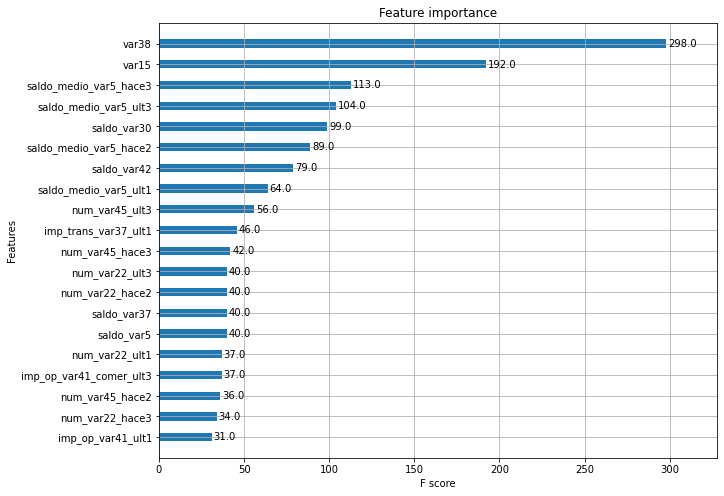

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

과제1_0525.
산탄데르 고객만족 예측을 lightgbm을 이용해서 수행하세요.(HyperOPT를 이용한 하이퍼파라미터 튜닝) 